In [488]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import mlab
import json, ast

import seaborn as sns
sns.set_style("whitegrid")

plt.style.use('classic')
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

In [233]:
df_domains = pd.read_csv('data/domain.csv',sep=',', encoding='latin1', keep_default_na=False)
df_links = pd.read_csv('data/links.csv',sep='|', encoding='latin1', keep_default_na=False)

## Distribution of news websites using AMP

This is the distribution of AMP-enabled vs non AMP-enabled websites in Africa. Out of the 56 countries and territories surveyed in Africa, 40 (71.5%) have at least one of their news website running on AMP. Out of 1431 domains collected, 194 domains are AMP-enabled i.e. around 13.5%. This represents quite a significant level of popularity of the AMP platform on the continent. The countries with the highest number of AMP-enabled news websites are KE, ZM, NG and ZA. Figure below shows a distribution of AMP vs Non-AMP websites by country, where there is at least 2 AMP-enabled domains.


In [234]:
z = []
for index, row in df_domains.iterrows():
    z.append(len(df_links.loc[df_links.domain==row['domain']]))
df_domains['amp_links_count'] = z

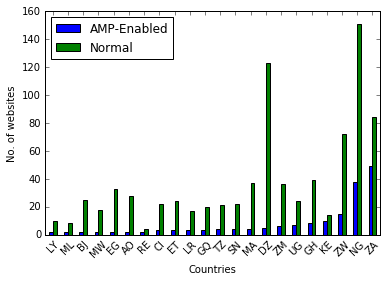

In [322]:
df1 = df_domains.iloc[:,[2,12]]
non_amp_domains = df1.loc[df1.amp_links_count == 0].groupby('cc').size()
amp_enabled_domains = df1.loc[df1.amp_links_count > 0].groupby('cc').size()

df2 = pd.DataFrame(columns=['cc','AMP-Enabled','Normal'])

for cc in df1['cc'].drop_duplicates():
    non_amp_size = 0
    amp_size = 0
    
    try:
        non_amp_size = non_amp_domains[cc]
        amp_size = amp_enabled_domains[cc]
    except KeyError:
        pass
    
    df2 = df2.append({'cc':cc, 'AMP-Enabled': amp_size, 'Normal':  non_amp_size}, ignore_index=True)
    
#df2['total'] = df2.apply(lambda row: row['AMP'] + row['Non-AMP'], axis=1)
#df2 = df2.iloc[:,[0,1,3]]

df2 = df2.loc[df2['AMP-Enabled']>1].sort_values(by='AMP-Enabled', ascending=True)

ax = df2.plot.bar(stacked=False, figsize=(6,4), x='cc', rot=45, fontsize=10)
plt.ylabel('No. of websites')
#plt.grid(True)
#plt.title("Distribution of AMP vs non-AMP websites by country", fontsize=10)
plt.xlabel('Countries')
plt.savefig("data/plots/distribution_website_amp_vs_nonamp.pdf")
plt.show()

## AMP Artifacts and Web QoE
AMP pages can be broken down in four components:
1. **Original url**: The original news page
2. **Original AMP url**: The AMP version of the original url, hosted by the news website
3. **AMP Viewer url**: The AMP page as hosted by google, it's domain is "www.google.com/amp/..."
4. **AMP Cache url**: The AMP page as cached by google in one of it's CDN, the domain is "www-example-com.cdn.ampproject.org/...."

We are going to run measurements SpeedChecker probes from the countries in which the websites are local to. The platform has a limit on the number of API calls and the number of tests you can run in one day, we have therefore selected a sample of around 500 URLs from all 40 countries that have at least one AMP-enabled domain. However, at the time of the experiment only 30 countries have active probes. For the sake of this experiment, we took a sample of 15 news links by country.

We have run Web QoE tests and extracted the following metrics:
1. DNSLookupTime: Time to resolve the domain
2. HTTPStatus: Status of the HTTP request
3. InitialConnection: Time for the initial handshake
4. NumberOfRequests: Number of individual requests made to download the page
5. PageLoadTime: Time it takes to load a page
6. SSLNegotiationTime: Time it takes to do the SSL handshake
7. TTFB: Time to first byte
8. TotalDownloadedBytes: Size of the page

# Web QoE analysis

In [314]:
df_ori_amp_results = pd.read_csv('data/ori_amp_url_results.csv', sep=';', encoding='utf-8', 
                                 keep_default_na=False, 
                                 converters={'InitialConnection':int, 'DNSLookupTime':int})
df_ori_amp_results = df_ori_amp_results[(df_ori_amp_results.HTTPStatus == '200')
                                        & (df_ori_amp_results.StatusText == 'OK')
#                                         & (df_ori_amp_results['InitialConnection'] > 0)
#                                         & (df_ori_amp_results['DNSLookupTime'] > 0)
#                                         & (df_ori_amp_results['TotalDownloadedBytes'] < 15000000)
                                       ] #outliers

df_amp_viewer_results = pd.read_csv('data/amp_viewer_url_results-1707201.csv', sep=';', encoding='utf-8', 
                                     keep_default_na=False,
                                    converters={'TotalDownloadedBytes':int}
                                   )                                  
df_amp_viewer_results = df_amp_viewer_results[(df_amp_viewer_results.HTTPStatus == 200)
                                              & (df_amp_viewer_results.StatusText == 'OK')
#                                               & (df_amp_viewer_results['PageLoadTime'] > 0)
                                               & (df_amp_viewer_results['TotalDownloadedBytes'] > 1020) 
                                             ]

# # df_amp_cdn_results = pd.read_csv('data/amp_cdn_url_results.csv', sep='|', encoding='utf-8', 
# #                                  keep_default_na=False,
# #                                  converters={'HTTPStatus':int, 'InitialConnection':int, 'DNSLookupTime':int})
# # df_amp_cdn_results = df_amp_cdn_results[(df_amp_cdn_results.HTTPStatus == '200') & 
# #                                         (df_amp_cdn_results.StatusText == 'OK') & 
# #                                         (df_amp_cdn_results.InitialConnection > 0) &
# #                                         (df_amp_cdn_results.DNSLookupTime > 0)]

df_url_results = pd.read_csv('data/url_results.csv', sep=';', encoding='utf-8',
                             keep_default_na=False,
                            converters={'InitialConnection':int, 'DNSLookupTime':int})
df_url_results = df_url_results[(df_url_results.HTTPStatus == 200) 
                                & (df_url_results.StatusText == 'OK')
#                                 & (df_url_results['InitialConnection'] > 0)
#                                 & (df_url_results['DNSLookupTime'] > 0)
#                                 & (df_url_results['PageLoadTime'] > 0)
#                                 & (df_url_results['TotalDownloadedBytes'] < 15000000)
                               ]

# #bytes into MB
df_ori_amp_results['TotalDownloadedBytes'] = df_ori_amp_results.apply(lambda x: int(x['TotalDownloadedBytes'])/1000000, axis=1)
df_amp_viewer_results['TotalDownloadedBytes'] = df_amp_viewer_results.apply(lambda x: int(x['TotalDownloadedBytes'])/1000000, axis=1)
# df_amp_cdn_results['TotalDownloadedBytes'] = df_amp_cdn_results.apply(lambda x: x['TotalDownloadedBytes']/1000000, axis=1)
df_url_results['TotalDownloadedBytes'] = df_url_results.apply(lambda x: int(x['TotalDownloadedBytes']/1000000), axis=1)

df_size1 = df_url_results.iloc[:,[1,6,9,11,12,13,14]]
df_size1 = df_size1.assign(Type='Web URL')

df_size2 = df_ori_amp_results.iloc[:,[1,6,9,11,12,13,14]]
df_size2 = df_size2.assign(Type='AMP URL')

df_size3 = df_amp_viewer_results.iloc[:,[1,6,9,11,12,13,14]]
df_size3 = df_size3.assign(Type='AMP Viewer URL')

# df_size4 = df_amp_cdn_results.iloc[:,[1,6,9,11,12,13,14]]
# df_size4 = df_size4.assign(Type='D. AMP CDN URL')

# df_sizes = pd.concat([df_size1, df_size2, df_size3, df_size4])
df_sizes = pd.concat([df_size1, df_size2, df_size3])

## CDFs
### TotalDownloadedBytes


### All in one

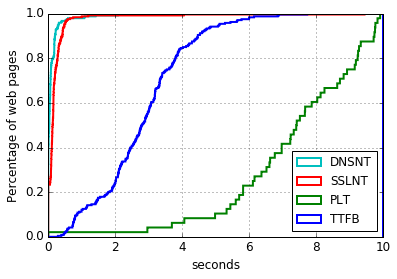

In [371]:
n_bins = 5000

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig, ax1 = plt.subplots(figsize=(6, 4))

labels = ['TTFB', 'PLT', 'SSLNT', 'DNSNT']

linestyles = ['solid','dashed']
#plot the cumulative histogram
n, bins, patches = ax1.hist([df_size1['TTFB'].values/1000, 
                            df_size1['PageLoadTime'].values/1000, 
                            df_size1['SSLNegotiationTime'].values/1000,
                            df_size1['DNSLookupTime'].values/1000
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, 
                            range=[0,10],
                           cumulative=True, label=labels)
                                    
# tidy up the figure
ax1.grid(True)
ax1.legend(loc='lower right')
#ax1.set_title('Web URL')
ax1.set_xlabel('seconds')
ax1.set_ylabel('Percentage of web pages')
#ax1.set_xscale('log')



# #plot the cumulative histogram
# n, bins, patches = ax2.hist([df_size2['TTFB'].values, 
#                             df_size2['PageLoadTime'].values, 
#                             df_size2['InitialConnection'].values, 
#                             df_size2['SSLNegotiationTime'].values,
#                             df_size2['DNSLookupTime'].values
#                            ], 
#                            n_bins, density=1, histtype='step', linewidth=2,
#                             range=[0,45000],
#                            cumulative=True, label=labels)
                                    
# # tidy up the figure
# ax2.grid(True)
# ax2.legend(loc='right')
# ax2.set_title('AMP URL')
# ax2.set_xlabel('ms')
# ax2.legend().set_visible(False)
# #ax2.set_xscale('log')



# #plot the cumulative histogram
# n, bins, patches = ax3.hist([df_size3['TTFB'].values, 
#                             df_size3['PageLoadTime'].values, 
#                             df_size3['InitialConnection'].values, 
#                             df_size3['SSLNegotiationTime'].values,
#                             df_size3['DNSLookupTime'].values
#                            ], 
#                            n_bins, density=1, histtype='step', linewidth=2,
#                             range=[0,45000],
#                            cumulative=True, label=labels)
                                    
# # tidy up the figure
# ax3.grid(True)
# ax3.legend(loc='right')
# ax3.set_title('AMP Viewer URL')
# ax3.set_xlabel('ms')
# #ax3.set_xscale('log')



plt.savefig("data/plots/CDF_WebURL_allinone.pdf")
plt.show()

##### TotalDownloadedBytes

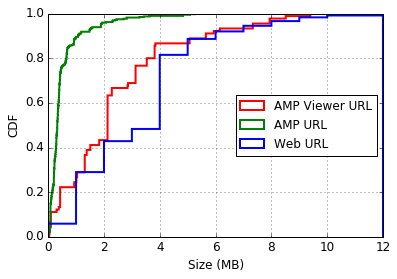

In [342]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL']

#plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['TotalDownloadedBytes'].values, 
                            df_size2['TotalDownloadedBytes'].values,
                            df_size3['TotalDownloadedBytes'].values
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,12],
                           cumulative=True, label=labels)
                                    
# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Page Size by URL Type')
ax.set_xlabel('Size (MB)')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_TotalDownloadedBytes.pdf")
plt.show()

### PageLoadTime


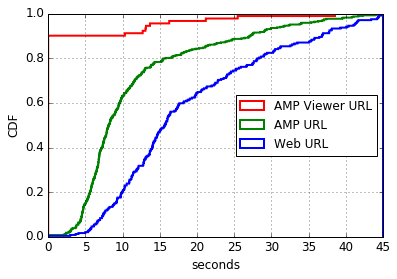

In [392]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['PageLoadTime'].values/1000, 
                            df_size2['PageLoadTime'].values/1000,
                            df_size3['PageLoadTime'].astype(np.int)/1000
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, 
                           range=[0,45],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Page Load Time by URL Type')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_PageLoadTime.pdf")
plt.show()

### TTFB


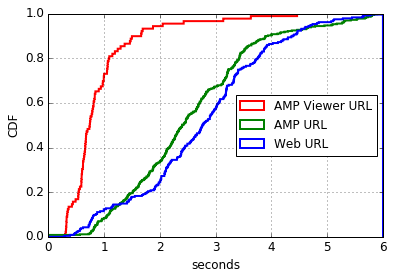

In [391]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['TTFB']/1000, 
                            df_size2['TTFB']/1000,
                            df_size3['TTFB'].astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,6],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('TTFB by URL Type')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_TTFB.pdf")
plt.show()

### SSLNegotiationTime


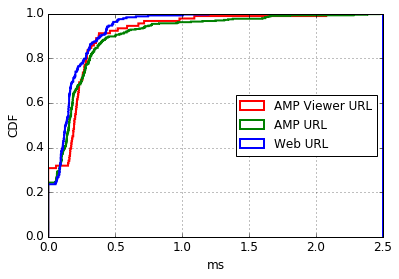

In [378]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['SSLNegotiationTime'], 
                            df_size2['SSLNegotiationTime'],
                            df_size3['SSLNegotiationTime'].astype(np.int)
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2500],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('SSLNegotiationTime by URL Type')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_SSLNegotiationTime.pdf")
plt.show()

### DNSLookupTime


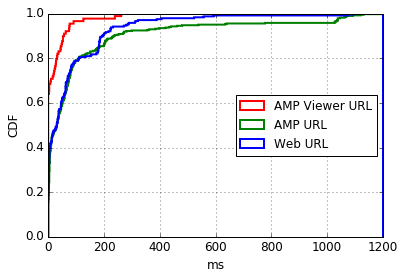

In [390]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['DNSLookupTime'], 
                            df_size2['DNSLookupTime'],
                            df_size3['DNSLookupTime'].astype(np.int)
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1200],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('DNSLookupTime by URL Type')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_DNSLookupTime.pdf")
plt.show()

### InitialConnection


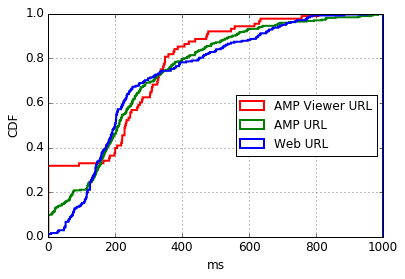

In [383]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['InitialConnection'], 
                            df_size2['InitialConnection'],
                            df_size3['InitialConnection']
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('InitialConnection by URL Type')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_InitialConnection.pdf")
plt.show()

## QoE EU/US vs Africa

In [498]:
def f(cc):
    if (cc in ["FR", "GB", "NL", "DE"]):
        return "EU"
    else:
        return "US"

df_url_results_euus = pd.read_csv('data/url_results_EUUS16072018.csv', sep=';', encoding='latin1',
                             keep_default_na=False)
df_url_results_euus = df_url_results_euus[(df_url_results_euus.HTTPStatus == '200') & 
                                 (df_url_results_euus.StatusText == 'OK') &
                                 (df_url_results_euus.PageLoadTime > 0)        
                            ]

df_amp_viewer_url_results_euus = pd.read_csv('data/amp_viewer_url_results_EUUS21072018.csv', sep=';', encoding='latin1',
                             keep_default_na=False)
df_amp_viewer_url_results_euus = df_amp_viewer_url_results_euus[(df_amp_viewer_url_results_euus.HTTPStatus == '200') & 
                                 (df_amp_viewer_url_results_euus.StatusText == 'OK') &
                                 (df_amp_viewer_url_results_euus.PageLoadTime > 0)]  


df_url_results_euus['probe_cc'] = df_url_results_euus.apply(lambda x: ast.literal_eval(x.ProbeInfo)['CountryCode'], axis = 1)
# df_url_results_euus['platform'] = df_url_results_euus.apply(lambda x: ast.literal_eval(x.ProbeInfo)['Platform'], axis = 1)
df_amp_viewer_url_results_euus['probe_cc'] = df_amp_viewer_url_results_euus.apply(lambda x: ast.literal_eval(x.ProbeInfo)['CountryCode'], axis = 1)

                                                                
df_url_results_euus['region'] = df_url_results_euus.apply(lambda x: f(x['probe_cc']), axis=1)
df_amp_viewer_url_results_euus['region'] = df_amp_viewer_url_results_euus.apply(lambda x: f(x['probe_cc']), axis=1)



### Web URL PageLoadTime EUUS vs AF

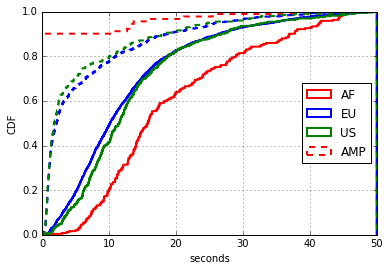

In [528]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['PageLoadTime']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['PageLoadTime']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['PageLoadTime']

df_amp_af = df_size3['PageLoadTime']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['PageLoadTime']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['PageLoadTime']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Page Load Time')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_PLT_EU-US-AF.pdf")
plt.show()

### DNSLookupTime

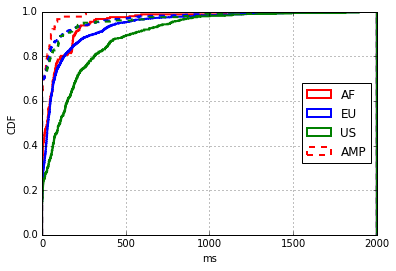

In [525]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['DNSLookupTime']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['DNSLookupTime']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['DNSLookupTime']

df_amp_af = df_size3['DNSLookupTime']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['DNSLookupTime']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['DNSLookupTime']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('DNS Lookup Time')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_DNS_EU-US-AF.pdf")
plt.show()

### SSLNegotiationTime

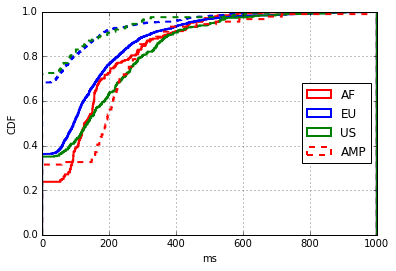

In [526]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['SSLNegotiationTime']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['SSLNegotiationTime']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['SSLNegotiationTime']

df_amp_af = df_size3['SSLNegotiationTime']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['SSLNegotiationTime']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['SSLNegotiationTime']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('SSL Negotiation Time')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_SSL_EU-US-AF.pdf")
plt.show()

### TTFB

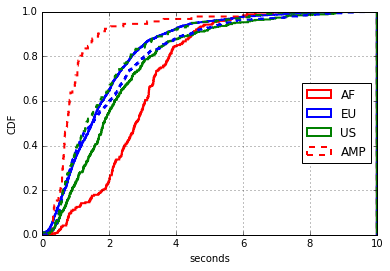

In [527]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['TTFB']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['TTFB']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['TTFB']

df_amp_af = df_size3['TTFB']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['TTFB']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['TTFB']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('TTFB')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_TTFB_EU-US-AF.pdf")
plt.show()

### Lab experiment

In [472]:
df_lab = pd.read_csv('data/all_load_times.csv',sep=',', encoding='latin1', keep_default_na=False,
                    converters={'carousel':int, 'google-search':int})


In [ ]:
df_carousel = df_lab.iloc[:,[0,1,5]]
df_carousel = df_carousel.assign(Type='Carousel')
df_carousel = df_carousel.rename({'website':'Website',
                                       'carousel':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_search = df_lab.iloc[:,[0,2,5]]
df_search = df_search.assign(Type='Google Search')
df_search = df_search.rename({'website':'Website',
                                       'google-search':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_mobile = df_lab.iloc[:,[0,3,5]]
df_mobile = df_mobile.assign(Type='Web URL')
df_mobile = df_mobile.rename({'website':'Website',
                                       'mobile':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_amp = df_lab.iloc[:,[0,4,5]]
df_amp = df_amp.assign(Type='AMP URL')
df_amp = df_amp.rename({'website':'Website',
                                       'original-amp':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_lab2 = pd.concat([df_carousel, df_search, df_mobile, df_amp], sort=True)

df_lab2



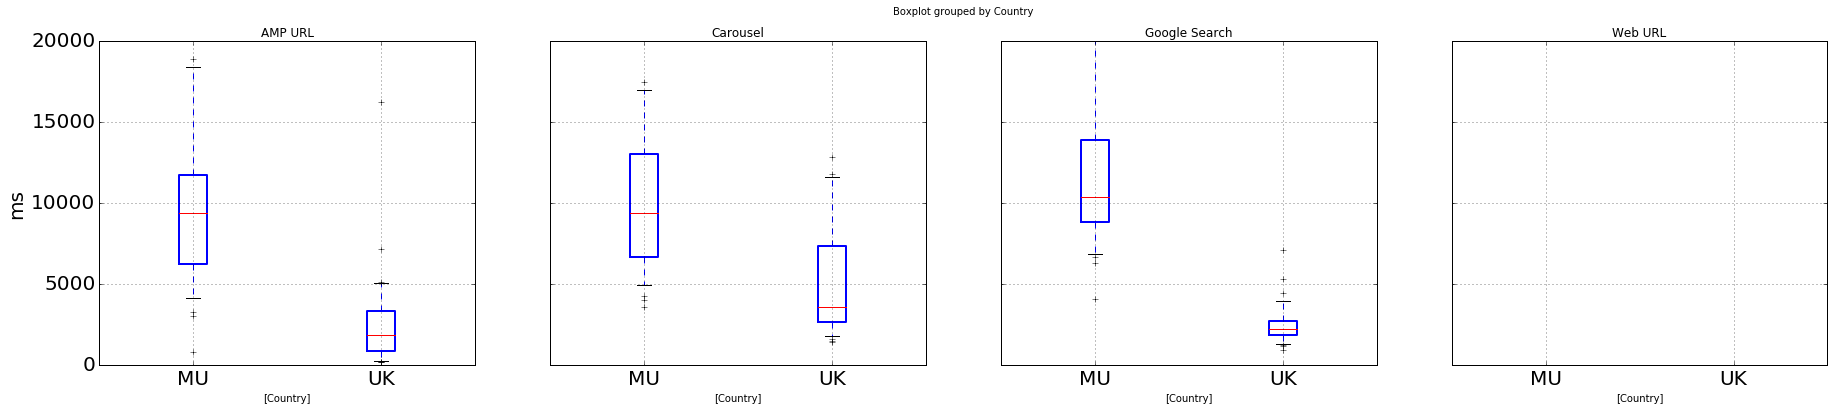

In [490]:
axes = df_lab2.groupby('Type').boxplot(column='LoadTime', 
                                       by=['Country'], figsize=(30,6), 
                                       layout=(1,4), whis=[5,95], 
                                       boxprops=boxprops,
                                       fontsize=20)

for ax in axes.values:
    ax.set_ylim(0, 20000)
    ax.set_ylabel("ms", fontsize=20)

plt.savefig("data/plots/boxplot_lab.pdf")
plt.show()